<a href="https://colab.research.google.com/github/SuhrudhSarathy/ForestDeptProj/blob/main/notebooks/Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms, datasets

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import datetime
import sys

dtype = torch.float
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
CLASSES = ['Acanthus Ilicifolius', 'Acrostichum aureum', 'Avicennia alba', 'Avicennia marina', 'Bruguiera cylindrica', 'Bruguiera gymnorrihza', 'Ceriops Tagal', 'Derris heterophylla', 'Excoecaria Agallocha', 'Kandelia Candel', 'Lumnizera recemosa', 'Rhizophora apiculata', 'Rhizophora mucronata', 'Sonneratia Alba', 'Sonneratia Saseolaris', 'aegiceras corniculatum']

In [3]:
resnet_model = "/content/drive/MyDrive/Aero_Forest_Project/resnet18_full.pth"
vgg_model = "/content/drive/MyDrive/Aero_Forest_Project/vgg_full.pth"

In [4]:
test_dir = "drive/MyDrive/Aero_Forest_Project/data/test"
data_transforms = {'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])}
test_dataset = datasets.ImageFolder(test_dir, data_transforms["test"])
test_data = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [5]:
class ResnetModel(nn.Module):
    def __init__(self):
        super(ResnetModel, self).__init__()
        self.conv_net = models.resnet18(pretrained=True)
        self.conv_net.fc = nn.Linear(self.conv_net.fc.in_features, len(CLASSES))

        # Load the state dict from the drive after first train
        self.load_state_dict(torch.load(resnet_model, map_location=device))
        # Freeze the parameters of the convnet (if you want a feature extractor only)
        self.to(dtype).to(device)

    def forward(self, X):
        X = self.conv_net(X)
        # returns the class only
        _, preds = torch.max(X, 1)
        # Return both to use for training
        return X, preds

In [6]:
class VGGModel(nn.Module):
    def __init__(self):
        super(VGGModel, self).__init__()
        self.conv_net = models.vgg16(pretrained=True)
        self.conv_net.classifier[6] = nn.Linear(self.conv_net.classifier[6].in_features, len(CLASSES))

        # Load the state dict from the drive after first train
        self.load_state_dict(torch.load(vgg_model, map_location=device))
        # Freeze the parameters of the convnet (if you want a feature extractor only)
        self.to(dtype).to(device)

    def forward(self, X):
        X = self.conv_net(X)
        # returns the class only
        _, preds = torch.max(X, 1)
        # Return both to use for training
        return X, preds

In [7]:
class Classifier():
    def __init__(self):
        """Core Classifier class that is an ensemble of the two models"""
        self.resnet = ResnetModel()
        self.vgg = VGGModel()

        self.image_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
        self.resnet.eval()
        self.vgg.eval()
        
    def forward(self, image):
        X_resnet, preds_resnet = self.resnet(image)
        X_resnet = F.softmax(X_resnet, dim=-1)
        X_vgg, preds_vgg = self.vgg(image)
        X_vgg = F.softmax(X_vgg, dim=-1)

        return self.ensemble(X_resnet, X_vgg)
    def ensemble(self, X_resnet, X_vgg):
        """Return the ensemble of both the networks"""
        X_ens = (X_resnet + X_vgg)*0.5
        _, preds = torch.max(X_ens, 1)
        return X_ens, preds

    def __call__(self, X):
        return self.forward(X)

In [8]:
model = Classifier()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

  0%|          | 0/922 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 922/922 [05:30<00:00,  2.79it/s]


Accuracy: 86.33405639913232


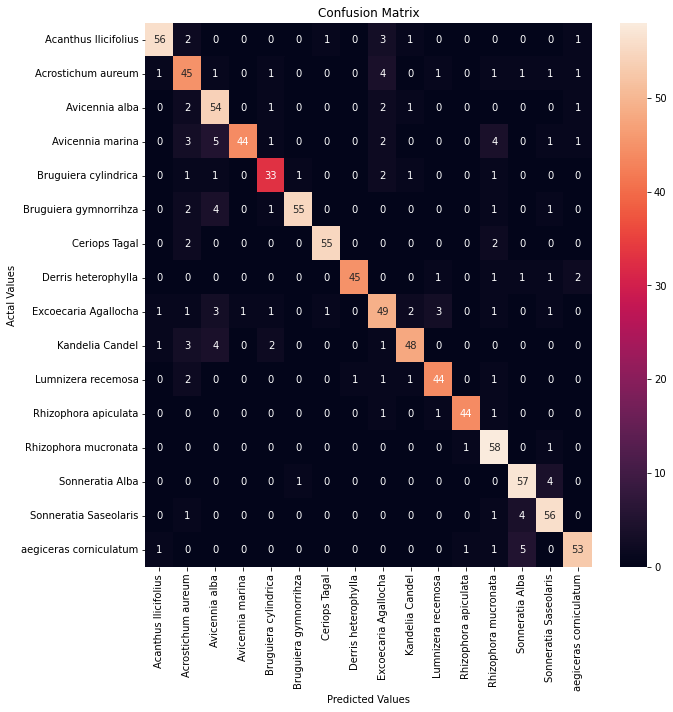

In [9]:
# trying to make a confusion matrix as well
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
from tqdm import tqdm
test_correct = 0
predicted_label = []
actual_label = []

logs = []

for input, label in tqdm(test_data):
    input = input.to(device)
    label = label.to(device)

    val, pred = model(input)
    val_percent = F.softmax(val, dim=-1)
    logs.append(f"Percentage: {torch.max(val_percent).item()}, Predicted Class: {pred.item()}, Correct Class: {label.item()}")
    predicted_label.append(pred.item())
    actual_label.append(label.item())

    if pred.item() == label.item():
        test_correct += 1

print(f"Accuracy: {test_correct * 100/len(test_data)}")
cm = confusion_matrix(actual_label, predicted_label)
cm_df = pd.DataFrame(cm, index=test_dataset.classes, columns=test_dataset.classes)

# plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm_df, annot=True)
plt.title("Confusion Matrix")
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show();

In [10]:
# Compute the F1 scrore
from sklearn.metrics import f1_score
f1 = f1_score(actual_label, predicted_label, average="weighted")
print(f1)

0.8642936332048085
